In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('train_2000.csv', )
train = train.drop(['Unnamed: 0'], axis=1)
train.head(5)

,image,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.3225,88.245,184.4820,88.5780,183.6495,115.551,184.4820,138.8610,183.4830,...,177.489,39.96,179.4870,37.9620,175.1580,38.1285,183.3165,40.959,171.4950,41.2920
1,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,176.8230,87.912,184.3155,87.9120,183.6495,115.551,184.1490,140.6925,183.4830,...,177.489,39.96,179.8200,37.9620,175.1580,38.2950,183.3165,40.959,171.9945,41.2920
2,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.8220,88.578,183.9825,88.4115,183.6495,115.551,184.1490,141.1920,183.3165,...,177.489,39.96,179.6535,38.1285,174.9915,38.1285,183.3165,40.959,171.9945,41.4585
3,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.8220,88.578,184.6485,88.5780,183.6495,115.551,184.1490,140.1930,183.3165,...,177.489,39.96,179.4870,38.1285,174.9915,38.2950,183.3165,40.959,171.8280,41.2920
4,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,177.8220,88.578,183.9825,88.5780,183.6495,115.551,183.6495,139.6935,183.6495,...,177.489,39.96,179.8200,38.1285,174.9915,38.4615,183.3165,40.959,172.1610,41.2920


In [4]:
train_paths = list(train['image'])

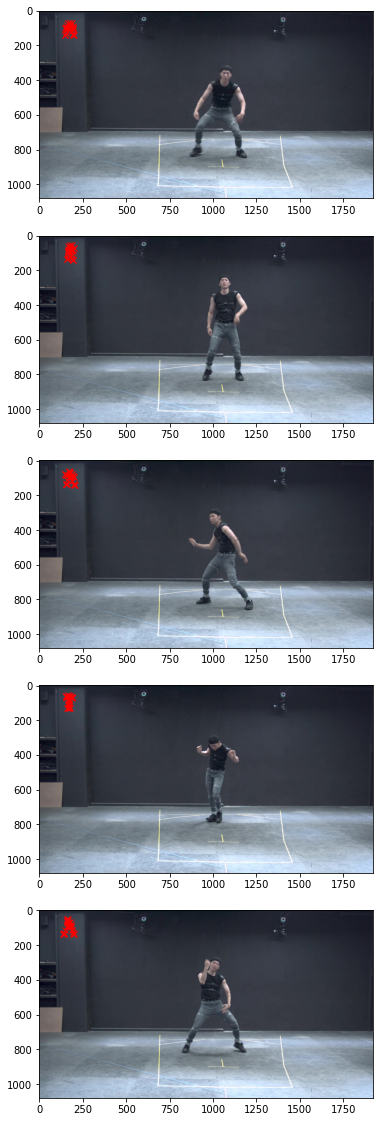

In [5]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1

In [6]:
def trainGenerator():
    for i in range(len(train)):
        img = tf.io.read_file(train['image'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 tensor로 변환
        img = tf.image.resize(img, [180,320]) # 이미지 resize 
        target = train.iloc[:,1:59].iloc[i,:] # keypoint 뽑아주기
        
        yield (img, target)

#generator를 활용해 데이터셋 만들기        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([180,320,3]),tf.TensorShape([58])))
train_dataset = train_dataset.batch(32).prefetch(1)

In [7]:
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Activation, Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [8]:
#간단한 CNN 모델을 적용합니다.

model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(58))

In [9]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [10]:
model.fit(train_dataset,epochs = 5, verbose=1)

Epoch 1/5
63/63 [==============================] - 439s 7s/step - loss: 1376.4667 - mae: 26.9840
Epoch 2/5
63/63 [==============================] - 413s 7s/step - loss: 604.2662 - mae: 19.5431
Epoch 3/5
63/63 [==============================] - 431s 7s/step - loss: 624.1344 - mae: 19.3461
Epoch 4/5
63/63 [==============================] - 466s 7s/step - loss: 577.8185 - mae: 18.7740
Epoch 5/5
63/63 [==============================] - 426s 7s/step - loss: 307.3036 - mae: 13.8769


In [43]:
test = pd.read_csv('test.csv', )
test = test.drop(['Unnamed: 0'], axis=1)
test.head(5)

,image,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1019,515,1046,512,1062,638,1049,742,1059,...,996,308,1008,293,984,292,1025,295,972,295
1,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1017,512,1042,511,1063,643,1049,745,1061,...,997,302,1010,284,986,285,1026,288,972,291
2,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1014,520,1041,518,1063,644,1049,748,1061,...,1000,296,1011,282,987,282,1027,287,975,289
3,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1012,523,1037,522,1068,647,1051,744,1060,...,1001,296,1013,281,989,282,1030,289,976,291
4,./K-pop 안무 영상/Training/[원천]100 (슈퍼엠)/083_I00_0...,1011,523,1052,520,1062,653,1042,763,1065,...,1002,297,1014,285,989,285,1032,295,975,297


In [44]:
test_paths = test['image']

In [45]:
X_test=[]

for test_path in tqdm(test_paths):
    img=tf.io.read_file(test_path)
    img=tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img, [180,320])
    X_test.append(img)

100%|██████████| 100/100 [00:01<00:00, 97.63it/s]


In [46]:
X_test=tf.stack(X_test, axis=0)
X_test.shape

TensorShape([100, 180, 320, 3])

In [47]:
pred=model.predict(X_test)

In [48]:
predict = pd.DataFrame(pred, columns = ["center_hip_x", "center_hip_y", "left_hip_x", "left_hip_y", "left_knee_x", "left_knee_y", "left_ankle_x", "left_ankle_y", "left_bigtoe_X", "left_bigtoe_y",
                "left_littletoe_x", "left_littletoe_y", "right_hip_x", "right_hip_y", "right_knee_x", "right_knee_y", "right_ankle_x", "right_ankle_y", "right_bigtoe_x", "right_bigtoe_y",
                "right_littletoe_x", "right_littletoe_y", "navel_x", "navel_y", "chest_x", "chest_y", "neck_x", "neck_y", "left_shoulder_x", "left_shoulder_y", "left_elbow_x", "left_elbow_y",
                "left_wrist_x", "left_wrist_y", "left_palm_thumb_x", "left_palm_thumb_y", "left_palm_pinky_x", "left_palm_pinky_y", "right_shoulder_x", "right_shoulder_y", "right_elbow_x", "right_elbow_y",
                "right_wrist_x", "right_wrist_y", "right_palm_thumb_x", "right_palm_thumb_y", "right_palm_pinky_x", "right_palm_pinky_y", "nose_x", "nose_y", "left_eye_x", "left_eye_y",
                "right_eye_x", "right_eye_y", "left_ear_x", "left_ear_y", "right_ear_x", "right_ear_y"])

predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,246.474518,123.193291,256.312653,131.564514,242.269775,153.748489,250.633759,183.790573,243.370377,190.441452,...,239.200882,77.443726,244.762970,86.854340,240.517975,77.653976,249.749222,79.485924,228.433502,68.794441
1,245.837524,120.477707,254.716339,129.408783,242.396576,153.838577,249.733292,181.781982,243.501007,189.959579,...,238.421143,76.418571,243.362976,86.425674,239.523819,78.155724,249.157410,80.025551,228.331009,70.080788
2,244.520538,117.593964,252.556503,127.921967,242.870224,154.143021,249.119064,180.723892,242.700485,188.803696,...,237.504837,76.739998,242.983276,86.099197,237.695282,79.458382,247.990570,80.343529,227.707397,72.398849
3,248.249832,118.343658,256.395233,129.657349,246.106155,156.836044,250.761993,182.387711,244.128647,192.169357,...,241.443420,76.547112,247.155182,86.399406,241.944214,79.708549,252.007660,81.396378,230.894531,74.052025
4,248.262939,117.600533,255.677597,129.998383,245.755219,157.804703,250.840317,181.805984,243.808807,191.757645,...,241.331818,77.139732,246.135468,87.469772,241.482574,79.890930,250.542282,82.913498,230.190704,75.343102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,247.122971,133.973572,258.995850,139.948761,240.987396,159.264954,258.389038,188.317215,252.717178,193.434677,...,241.516190,92.283455,241.998245,99.103638,238.134369,85.275169,245.606262,88.496979,226.792969,75.381493
96,247.417587,131.274094,259.063141,137.993744,241.441803,158.465591,256.724518,187.928696,250.683884,194.097122,...,241.339706,89.667191,243.545654,96.217072,238.180130,83.925934,247.200958,86.171097,227.348022,74.664909
97,248.364532,129.133743,259.557129,137.086166,243.993134,158.719009,257.350372,188.586716,252.295578,195.474594,...,242.543015,87.880272,245.790802,93.597862,239.543137,83.819946,249.740814,84.803436,230.085114,74.770515
98,248.352814,127.150436,258.879150,135.360504,244.751984,157.779068,255.869446,188.146500,250.588638,195.406601,...,241.648727,84.996117,246.697327,90.701729,239.374084,82.020103,251.003632,82.969284,229.934540,73.521637


In [49]:
predict = predict * 6
predict

,center_hip_x,center_hip_y,left_hip_x,left_hip_y,left_knee_x,left_knee_y,left_ankle_x,left_ankle_y,left_bigtoe_X,left_bigtoe_y,...,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y
0,1478.847168,739.159729,1537.875977,789.387085,1453.618652,922.490967,1503.802490,1102.743408,1460.222290,1142.648682,...,1435.205322,464.662354,1468.577881,521.126038,1443.107910,465.923859,1498.495361,476.915527,1370.601074,412.766663
1,1475.025146,722.866211,1528.298096,776.452698,1454.379395,923.031494,1498.399780,1090.691895,1461.006104,1139.757446,...,1430.526855,458.511414,1460.177856,518.554077,1437.142944,468.934326,1494.944458,480.153320,1369.986084,420.484741
2,1467.123291,705.563782,1515.338989,767.531799,1457.221313,924.858154,1494.714355,1084.343384,1456.202881,1132.822144,...,1425.029053,460.440002,1457.899658,516.595215,1426.171631,476.750305,1487.943359,482.061157,1366.244385,434.393097
3,1489.499023,710.061951,1538.371338,777.944092,1476.636963,941.016235,1504.572021,1094.326294,1464.771851,1153.016113,...,1448.660522,459.282654,1482.931152,518.396423,1451.665283,478.251282,1512.045898,488.378265,1385.367188,444.312134
4,1489.577637,705.603210,1534.065552,779.990295,1474.531250,946.828247,1505.041870,1090.835938,1462.852783,1150.545898,...,1447.990967,462.838379,1476.812744,524.818604,1448.895508,479.345581,1503.253662,497.480988,1381.144287,452.058594
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1482.737793,803.841431,1553.975098,839.692566,1445.924316,955.589722,1550.334229,1129.903320,1516.303101,1160.608032,...,1449.097168,553.700745,1451.989502,594.621826,1428.806152,511.651001,1473.637573,530.981873,1360.757812,452.288940
96,1484.505493,787.644531,1554.378906,827.962463,1448.650879,950.793579,1540.347168,1127.572144,1504.103271,1164.582764,...,1448.038208,538.003174,1461.273926,577.302429,1429.080811,503.555603,1483.205811,517.026611,1364.088135,447.989441
97,1490.187256,774.802490,1557.342773,822.516968,1463.958740,952.314087,1544.102295,1131.520264,1513.773438,1172.847534,...,1455.258057,527.281616,1474.744873,561.587158,1437.258789,502.919678,1498.444824,508.820618,1380.510742,448.623108
98,1490.116943,762.902588,1553.274902,812.163025,1468.511963,946.674438,1535.216675,1128.879028,1503.531860,1172.439575,...,1449.892334,509.976685,1480.183960,544.210388,1436.244507,492.120605,1506.021729,497.815704,1379.607178,441.129822


In [50]:
my_test = pd.concat([test['image'], predict], axis=1)

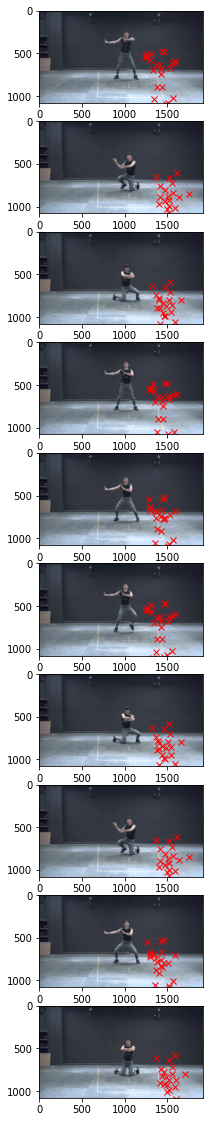

In [53]:
# 학습시킬 때 좌표값에 1/6했으니 테스할때 다시 6곱해준 것

plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(test_paths),10):
    
    plt.subplot(10,1, count)
    
    img_sample_path = test_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = my_test.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count+=1
    

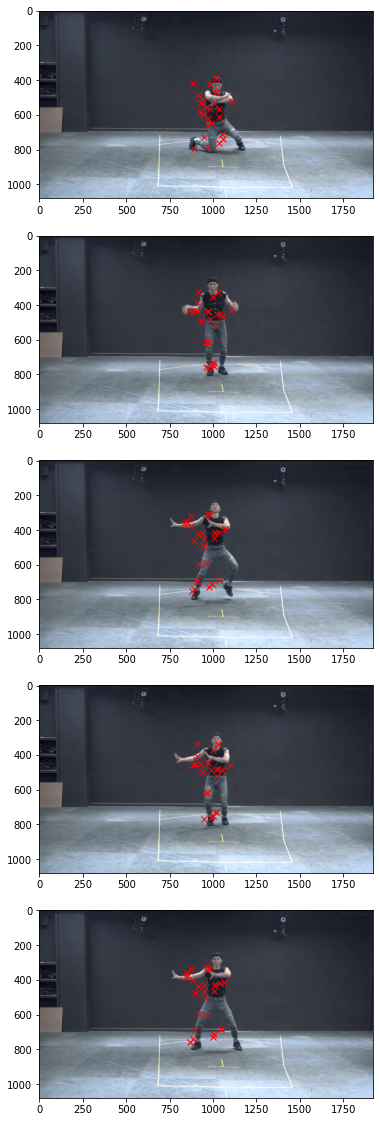

In [29]:
# 좌표갑에 4곱한것(그냥 추측성)

plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(test_paths),10):
    
    plt.subplot(10,1, count)
    
    img_sample_path = test_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = my_test.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1